## JUMIA-PRODUCTS-RECOMMENDATION-AND-PRODUCT-REVIEW-SYSTEM

### Overview

The growth of e-commerce in Kenya has been exponential, with platforms like Jumia attracting large numbers of users. However, users frequently encounter challenges in locating relevant products due to expansive and sometimes disorganized product catalogs. Moreover, the limited use of recommendations and unreliable review systems further complicate the shopping experience, leading to reduced user satisfaction and lower conversion rates. To address these issues, we propose a recommendation and sentiment analysis system that leverages interaction history and user feedback. This system aims to provide more relevant recommendations and insights from customer sentiments, enabling Jumia to better serve its users and enhance its retail offerings.

### Problem Statement

The problem of finding relevant products on Jumia’s extensive catalog significantly affects customer satisfaction and conversion rates. Current limitations include:  

* Inadequate product recommendations based on user behavior, which leads to a lack of personalization.
* An unreliable rating and review system, leaving customers with limited insights into product quality.
* Limited retailer insights into customer sentiment, hindering their ability to refine offerings and optimize marketing strategies.
  
These issues reduce user satisfaction, decrease sales, and limit the potential for enhanced customer-retailer relationships on Jumia.

### Stakeholders

**Primary Users (Consumers)**: Customers who frequently shop on Jumia and need relevant recommendations to streamline their product search and improve purchase decisions.

**Retailers/Sellers**: Businesses and individual sellers on Jumia who seek insights into customer preferences and sentiment to better tailor their product offerings and marketing strategies.

**Jumia Management**: The platform administrators who aim to improve customer satisfaction, engagement, and conversion rates through improved site functionality.

### Objectives

* *Develop a Recommendation System*:

Create an intelligent recommendation engine that uses customer interaction history, preferences, and similar behavior patterns to provide relevant product recommendations.

* *Implement Sentiment Analysis*:

Extract sentiments from customer reviews to offer meaningful feedback, categorizing it as positive, negative, or neutral. This feedback will help refine recommendations and improve customer trust in the platform.

* *Enhance User Experience*:

Improve customer satisfaction by reducing the time and effort needed to find relevant products, potentially increasing conversion rates.

* *Provide Insightful Retailer Analytics*:

Equip sellers with sentiment analysis reports and recommendation patterns to refine product and marketing offerings based on customer preferences.

* *Support Kenyan E-commerce Growth*:

Contribute to the development of the e-commerce sector in Kenya by addressing key pain points in product discoverability and review reliability on Jumia.

### Expected Benefits

* **For Customers**: More personalized recommendations, improved trust through reliable sentiment analysis, and an overall enhanced shopping experience.

* **For Retailers**: Access to better customer insights and sentiment data, allowing them to optimize product listings, improve customer engagement, and refine marketing strategies.

* **For Jumia**: Increased user satisfaction and conversion rates, resulting in stronger brand loyalty and a more competitive edge in the Kenyan e-commerce market.

### Data Understanding

We scraped data from [jumia](https://www.jumia.co.ke/) which is an online shop with more than 15 categories of products but decided to only have 15 categories

### Exploratory Data Ananlysis

Importing relevant libraries

In [1]:
#import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE 
from scipy import stats as stats
from imblearn.pipeline import Pipeline as imbpipe
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,\
roc_curve,roc_auc_score,classification_report, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# import tensorflow as tf
# from tensorflow import keras
from scipy.sparse import csr_matrix
from sklearn.svm import SVC
from sklearn.exceptions import NotFittedError
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow import keras
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
#from surprise import SVD, Dataset, Reader
#from surprise.model_selection import train_test_split
import pickle
import dill

import warnings
warnings.filterwarnings('ignore')

### Data Understanding

Loading the scraped dataset

In [2]:
# Load the data into a dataframe and read the first five rows
df = pd.read_csv('./Data/combined_dta.csv', encoding='ISO-8859-1')

df.head()

FileNotFoundError: [Errno 2] No such file or directory: './Data/combined_dta.csv'

In [ ]:
# Get the number of rows and columns
print(df.shape, '\n')

print(f'The scraped data have {df.shape[0]} rows and {df.shape[1]} columns')

(60400, 20) 

The scraped data have 60400 rows and 20 columns


To arrive at this number of rows, we ensured that we scraped as much data as possible both from the product categories and sub-categories despite being blocked from sourcing most of it but we believe that this dataset will be helpful in achieving our objectives

In [ ]:
# Statistical summary

df.describe()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,link,link-href,see_all,see_all-href,review_title,review,ratings,user_name,date,see_all_link,see_all_link-href,Category
count,60400,60400,60400,60400,60395,60266,60266,39535,28080,35961,40367,40361,37656,39262,37569,37569,37569,2,2,60400
unique,60135,248,25445,26684,22858,26617,7993,1692,35,706,104,7791,13112,25450,6,9230,1382,1,1,14
top,https://www.jumia.co.ke/ps4-pad-dual-shock-4-w...,https://www.jumia.co.ke/mobile-phones/,Black Friday dealOut of StockOfficial StoreHis...,https://www.jumia.co.ke/hisense-ax-3100g-3.1ch...,Hisense AX-3100G 3.1ch Dolby Atmos Home Cinema...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,KSh 999,Fashion,2,https://www.jumia.co.ke/mobile-phones/?page=2#...,See All,https://www.jumia.co.ke/catalog/productratings...,I like it,Good,5 out of 5,by Brian,28/10/2024,see_all_link,see_all_link-href,Fashion
freq,17,1448,192,192,192,192,528,10798,15081,488,37759,192,3381,309,21667,363,554,2,2,11656


In [ ]:
# Let's look at the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60400 entries, 0 to 60399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   web-scraper-order      60400 non-null  object
 1   web-scraper-start-url  60400 non-null  object
 2   product                60400 non-null  object
 3   product-href           60400 non-null  object
 4   product_name           60395 non-null  object
 5   image                  60266 non-null  object
 6   price                  60266 non-null  object
 7   brand                  39535 non-null  object
 8   link                   28080 non-null  object
 9   link-href              35961 non-null  object
 10  see_all                40367 non-null  object
 11  see_all-href           40361 non-null  object
 12  review_title           37656 non-null  object
 13  review                 39262 non-null  object
 14  ratings                37569 non-null  object
 15  user_name          

In [ ]:
print(f'We have {df.shape[1]} columns in our dataset', '\n')

print('The columns are:')

df.columns

We have 20 columns in our dataset 

The columns are:


Index(['web-scraper-order', 'web-scraper-start-url', 'product', 'product-href',
       'product_name', 'image', 'price', 'brand', 'link', 'link-href',
       'see_all', 'see_all-href', 'review_title', 'review', 'ratings',
       'user_name', 'date', 'see_all_link', 'see_all_link-href', 'Category'],
      dtype='object')

To have better understanding of what each column entails and what they mean, have a look at the `column_description.txt` file in the `Data` folder

### Data Cleaning

In [ ]:
# Checks for row duplicates
df.duplicated().sum()

4

In [ ]:
# Remove row duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
print(f'After dropping the 49 rows with duplicates, we now remaining with {df.shape[0]} rows and {df.shape[1]} columns')

After dropping the 49 rows with duplicates, we now remaining with 60396 rows and 20 columns


In [ ]:
# Function to calculate the percentage of null values in every column

def null_percentages(df):
    
    # Calculate the number of missing values and their percentage
    null_values = df.isnull().sum()
    null_percentage = (null_values / df.shape[0]) * 100
    
    # Create a DataFrame with the results
    missing_data = pd.DataFrame({'Null Values': null_values, 'Percentage': null_percentage})

    # Filter out columns with no missing values and sort by 'Missing Values'
    missing_data = missing_data[missing_data['Null Values'] > 0].sort_values(by='Null Values', ascending=False)

    return missing_data

In [ ]:
null_percentages(df)

,Null Values,Percentage
see_all_link,60394,99.996689
see_all_link-href,60394,99.996689
link,32320,53.513478
link-href,24435,40.457977
ratings,22827,37.795549
user_name,22827,37.795549
date,22827,37.795549
review_title,22740,37.651500
review,21134,34.992384
brand,20865,34.546990


We have lots of columns with over **35%** null values and so, we are going to of how to deal with the null values and at the same time maintain as much data as possible  

Let's plot a heat map for the missing values

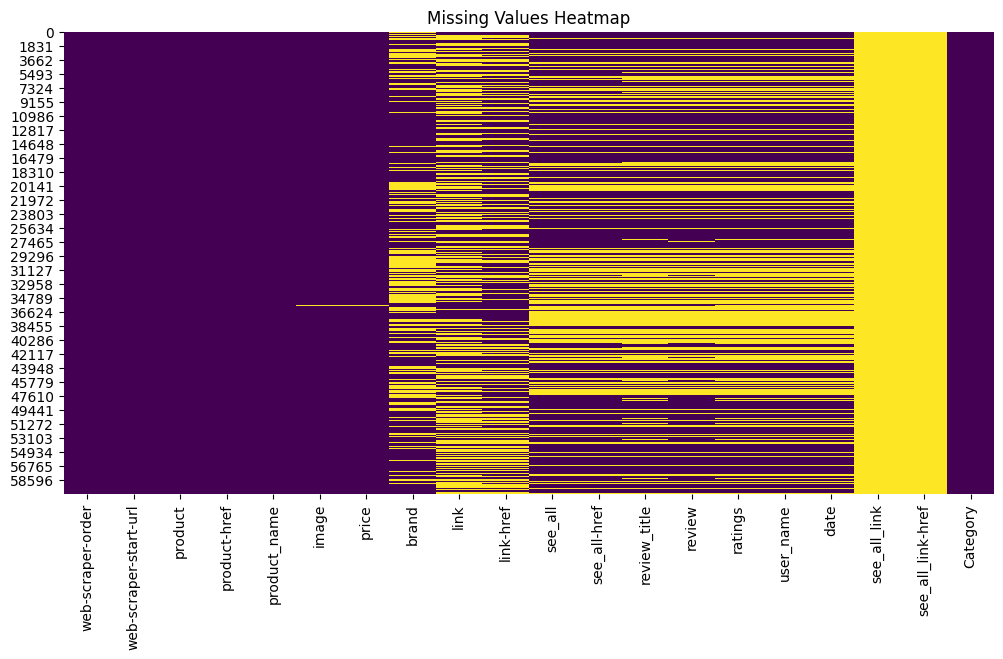

In [ ]:
# Plot missing values as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show();

Notable Columns with Missing Data:

`review_title`  
`link-href`   
`user_rating`   
Several columns related to scraping and product information

*Data Quality Implications*:

This visualization helps identify:

* Which columns need data cleaning
* Patterns of missing data that might indicate scraping issues
* Columns that might need to be dropped or imputed
* Potential systematic issues in data collection

In [ ]:
df.drop(['see_all_link-href', 'see_all_link', 'see_all-href', 'see_all', 'link-href', 'link'], axis=1, inplace=True,)
df.shape

(60396, 14)

In [ ]:
df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'product', 'product-href',
       'product_name', 'image', 'price', 'brand', 'review_title', 'review',
       'ratings', 'user_name', 'date', 'Category'],
      dtype='object')

We are now remaining with 14 columns. 

Since we have got further information that we need from other columns, we going to extract **ratings** from `ratings` column, **sub_category** from `web-scraper-start-url` column, **overall_ratings** from `product` column and **rating_count** from `product` column

In [ ]:
# Extract ratings, sub_category, overall_ratings, date, month, year and ratings_count

df['ratings'] = df['ratings'].str.extract(r'(\d+)').astype(float)

df['sub_category'] = df['web-scraper-start-url'].str.extract(r'\.ke/([^/]+)/')

# Step 1: Extract initial rating
df['overall_ratings'] = df['product'].str.extract(r'(\d+\.\d+|\d+)\s*out of 5')[0].astype(float)

# Step 2: Correct ratings above 5.0 by extracting the last segment of the number
df['overall_ratings'] = df['overall_ratings'].apply(lambda x: float(str(x).split('.')[0][-1] + '.' + str(x).split('.')[-1]) if x > 5.0 else x)

df['ratings_count'] = df['product'].str.extract(r'(\d+) out of 5\((\d+)\)')[1].astype(float)

In [ ]:
# Stripping 'by' from user_name

df['user_name'] = df['user_name'].str.lstrip('by')

In [ ]:
# Function to remove the currency and calculate the average of the price range

def convert_price(price):
    # Remove non-numeric characters (i.e.currency symbols)
    cleaned_price = re.sub(r"[^\d.-]", "", str(price))
    
    # Handle ranges
    if '-' in cleaned_price:
        try:
            low, high = map(float, cleaned_price.split('-'))
            return (low + high) / 2
        except ValueError:
            return None  # Return None if conversion fails
    else:
        try:
            return float(cleaned_price)  # Convert single prices to float
        except ValueError:
            return None

In [ ]:
# Apply the conversion function to the price column

df['price'] = df['price'].apply(convert_price)

In [ ]:
# Show the first 5 rows of the DataFrame

df.head()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,review_title,review,ratings,user_name,date,Category,sub_category,overall_ratings,ratings_count
0,1730407108-1,https://www.jumia.co.ke/computer-accessories/,Black Friday dealLaptop Skin Wrap Vinyl from 1...,https://www.jumia.co.ke/generic-laptop-skin-wr...,Laptop Skin Wrap Vinyl from 12-17.0 inches Lap...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,748.0,NaN,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,OKAY,"Working, feels cheap",3.0,WILFRED,28/04/2022,Computing,computer-accessories,4.1,7.0
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,okay,A bit big for a regular laptop bag... The fanc...,4.0,Michael,08/07/2021,Computing,computer-accessories,4.1,7.0
3,1730407114-4,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLexar 2.5"" SATA 256GB Laptop ...",https://www.jumia.co.ke/lexar-2.5-sata-256gb-l...,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3799.0,Lexar,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
4,1730407116-5,https://www.jumia.co.ke/computer-accessories/,"WD External Portable Hard Drive-2TBKSh 15,000",https://www.jumia.co.ke/wd-external-portable-h...,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,15000.0,WD,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN


In [ ]:
print(f'We have {df.shape[0]} rows and {df.shape[1]} columns after extraction and addition of new columns')

We have 60396 rows and 17 columns after extraction and addition of new columns


We now going to remove columns that are no longer useful

In [ ]:
df.drop(['web-scraper-start-url', 'product', 'date'], axis=1, inplace=True)

In [ ]:
df.head()

,web-scraper-order,product_name,image,price,brand,review_title,review,ratings,user_name,Category,sub_category,overall_ratings,ratings_count
0,1730407108-1,Laptop Skin Wrap Vinyl from 12-17.0 inches Lap...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,748.0,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
1,1730407112-2,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,OKAY,"Working, feels cheap",3.0,WILFRED,Computing,computer-accessories,4.1,7.0
2,1730407112-3,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,okay,A bit big for a regular laptop bag... The fanc...,4.0,Michael,Computing,computer-accessories,4.1,7.0
3,1730407114-4,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3799.0,Lexar,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
4,1730407116-5,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,15000.0,WD,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN


In [ ]:
# Check for null values and their percentage

null_percentages(df)

,Null Values,Percentage
ratings,22829,37.798861
user_name,22827,37.795549
review_title,22740,37.651500
review,21134,34.992384
brand,20865,34.546990
overall_ratings,20680,34.240678
ratings_count,20680,34.240678
price,142,0.235115
image,130,0.215246
sub_category,109,0.180476


As per the above output, `ratings`, `user_name` and `review_title` which have over **35%** missing values  

Let's have a look at the statistical summary for the numerical columns

In [ ]:
df.describe()

,price,ratings,overall_ratings,ratings_count
count,6.025400e+04,37567.000000,39716.000000,39716.000000
mean,5.251527e+03,4.056645,4.100368,90.487436
std,1.764522e+04,1.358270,0.516007,281.591032
min,3.000000e+01,1.000000,1.000000,1.000000
25%,7.240000e+02,3.000000,3.800000,12.000000
50%,1.386000e+03,5.000000,4.100000,31.000000
75%,3.850000e+03,5.000000,4.400000,71.000000
max,1.370668e+06,5.000000,5.000000,5225.000000


#### Imputation

In [ ]:
# Impute less critical columns

df['brand'].fillna('Unknown', inplace=True)

df['review_title'].fillna('No Title', inplace=True)

df['user_name'].fillna('No name', inplace=True)

df['ratings'].fillna(0, inplace=True)

# df['review'].fillna('No review', inplace=True)

# df['overall_ratings'].fillna(0, inplace=True)

df['ratings_count'].fillna(0, inplace=True)

In [ ]:
# Drop the remaining negligible null values

df = df.dropna()

In [ ]:
null_percentages(df)

,Null Values,Percentage


In [ ]:
df.shape

(38747, 13)

### Exploratory Data Analysis

#### *Category Distribution*

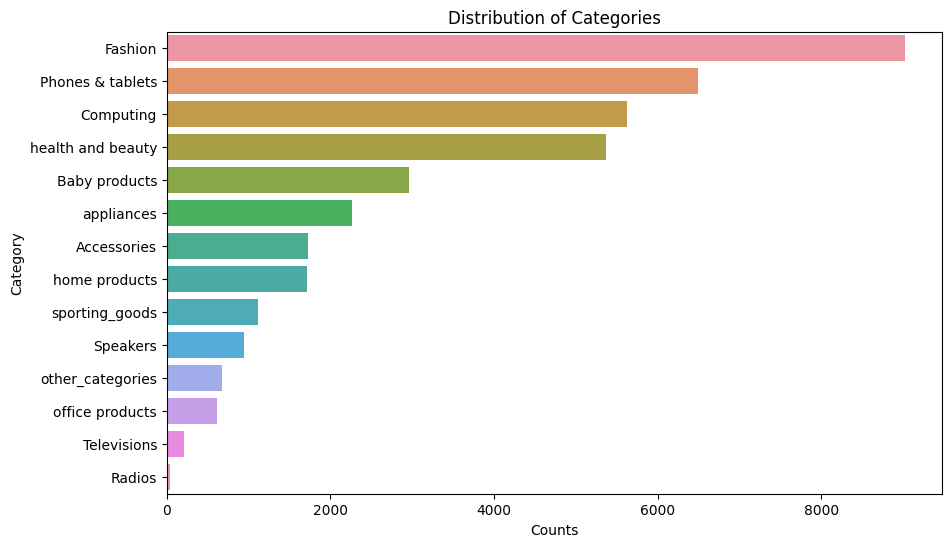

In [ ]:
# Categorical column
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', 
              data=df,
              order=df['Category'].value_counts().index)
plt.title('Distribution of Categories')
plt.xlabel('Counts')
plt.ylabel('Category')
plt.show();

**Interpretation**

- The top few categories have significantly more products compared to those at the bottom, suggesting that certain categories (like `Fashion` and `Phone & tablets`) are highly populated in your dataset.  
- There’s a clear drop-off in frequency as you move down the list, which could indicate that some categories are more popular or that more products have been uploaded for those categories in the e-commerce catalog.

**Insights**

* *Customer Interest*: The top categories could reflect higher customer interest or demand, as vendors may upload more products in these areas.

* *Inventory Planning*: Retailers might focus more on stocking and promoting items in the most frequent categories.
* *Recommendation System Focus*: A recommendation system might prioritize building recommendations for these popular categories since they are likely to have more diverse options.

#### *Prices Distribution*

In [ ]:
# Distribution Analysis
def plot_distribution(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=20)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show();

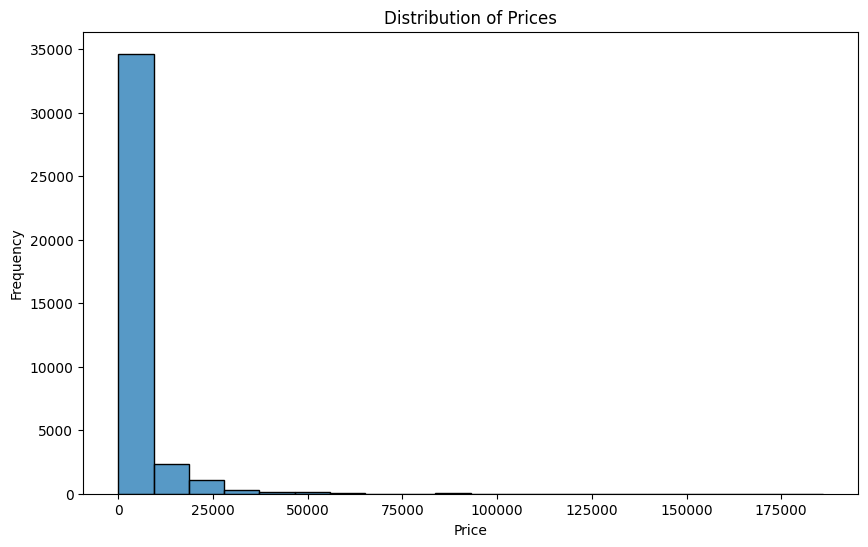

In [ ]:
plot_distribution(df['price'], 'Distribution of Prices', 'Price', 'Frequency')

**Interpretation and Possible Implications**:

* *Imbalanced Dataset*: If you’re building a recommendation or classification system, this imbalance could bias the system towards the dominant category, potentially affecting its effectiveness across less-represented categories.

* *Customer Demand or Inventory Bias*: This could indicate a high customer demand for the dominant category, or it could reflect an inventory or data collection bias where most of the available products fall under this single category.

This kind of skewed distribution is common in datasets where one category or product type is significantly more popular or frequently added than others. 

In [ ]:
# Since price is positively skewed, 

# Calculate IQR to detect outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[df['price'] > threshold]

print("Number of outliers:", len(outliers))
print(outliers[['product_name', 'price']].sort_values(by='price', ascending=False))

Number of outliers: 6091
                                            product_name     price
42794  LG 75UP7760 75" UHD 4K HDR WebOS Smart AI Thin...  186000.0
50015  Ramtons RF/265 - 527L Side By Side LED Fridge ...  149300.0
50016  Ramtons RF/265 - 527L Side By Side LED Fridge ...  149300.0
49870  Samsung RT31K3082S8 - Top Freezer Refrigerator...   93999.0
50993  Ramtons RW/153- 12KG Front Load Washing Machin...   93500.0
...                                                  ...       ...
52422  Ramtons RG/518- 2 Burner Gas Cooker- Stainless...    4899.0
52421  Ramtons RG/518- 2 Burner Gas Cooker- Stainless...    4899.0
39809              Complete Kit Blue Roller Skates Shoes    4899.0
39810              Complete Kit pink Roller Skates Shoes    4894.0
24535  Nokia C2-05 Slide Cell Phone Bluetooth FM Radi...    4880.0

[6091 rows x 2 columns]


#### *Top 10 Sub Categories*

In [ ]:
# Analyze the distribution of items across different subcategories

subcategory_counts = df['sub_category'].value_counts()

subcategory_counts

sub_category
mobile-accessories         1806
mobile-phones              1382
smartphones                1099
audio-video-accessories     806
computer-accessories        803
                           ... 
baby-changing-tables          2
baby-bath-toys                2
baby-nursery-mattresses       1
skin-care-sets-kits           1
motorcycle-powersports        1
Name: count, Length: 204, dtype: int64

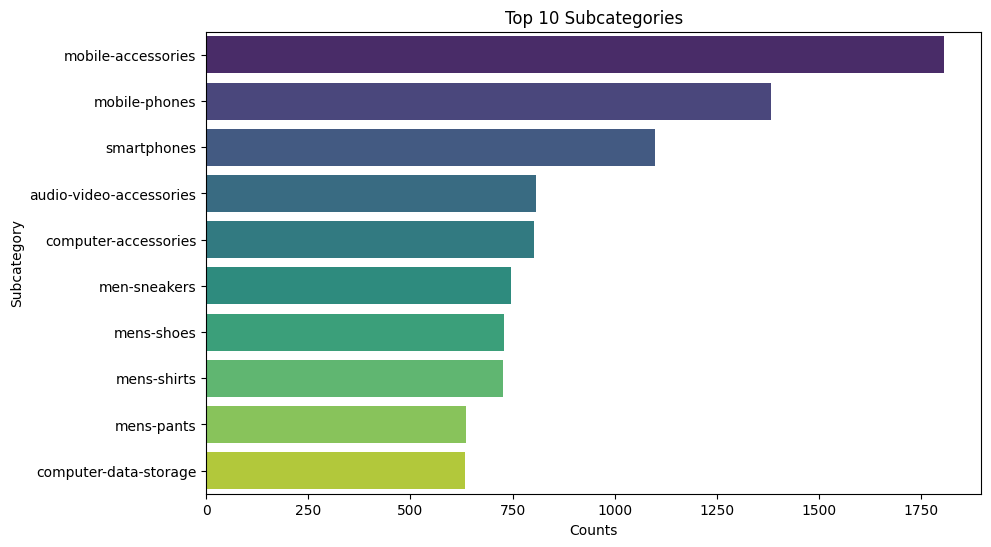

In [ ]:
# Get the top 10 subcategories in descending order
top_10_subcategories = subcategory_counts.head(10)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_subcategories.values, y=top_10_subcategories.index, palette='viridis')
plt.title('Top 10 Subcategories')
plt.xlabel('Counts')
plt.ylabel('Subcategory')
plt.show();

**Potential Insights**

* *Customer Interest or Inventory Focus*: the top subcategories likely represent popular product types, high customer demand, or a focus on certain items.

#### *Bottom 10 Sub Categories*

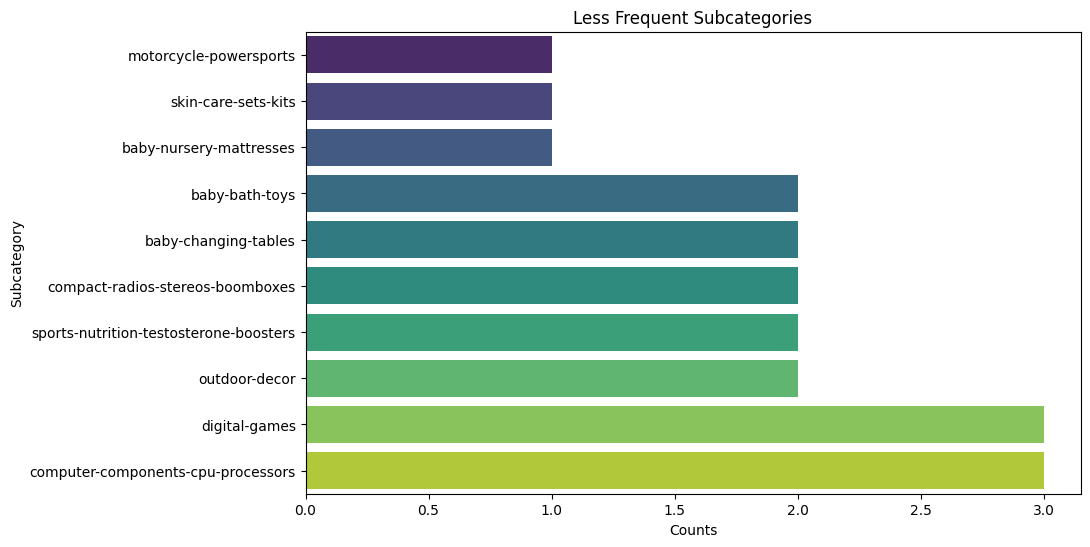

In [ ]:
# Get the top 10 subcategories in descending order and then reverse them for ascending order
bottom_10_subcategories = subcategory_counts.tail(10).iloc[::-1]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=bottom_10_subcategories.values, y=bottom_10_subcategories.index, palette='viridis')
plt.title('Less Frequent Subcategories')
plt.xlabel('Counts')
plt.ylabel('Subcategory')
plt.show();

The above plot shows less frequent sub-categories potentially indicating lower popularity or inventory for these items.

#### *Users*

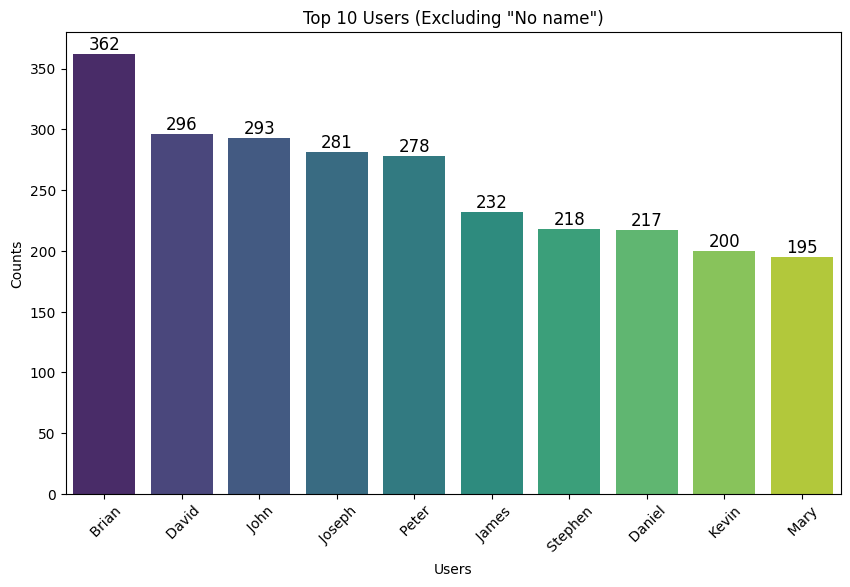

In [ ]:
# Filter out 'No name' entries from the user_name column
filtered_users = df[df['user_name'] != 'No name']

# Get the top 10 users by count
top_10_users = filtered_users['user_name'].value_counts().head(10)
    
# Plot the vertical bar chart for the top 10 users
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_users.index, y=top_10_users.values, palette='viridis')
# Annotate the bars with the count values
for i, value in enumerate(top_10_users.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)
plt.title('Top 10 Users (Excluding "No name")')
plt.xlabel('Users')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show();

**User Engagement**:

This distribution suggests that a few users are significantly more engaged than others in providing feedback. These top users are repeat customers or highly active reviewers who frequently purchase and leave feedback on products.

#### *Ratings*

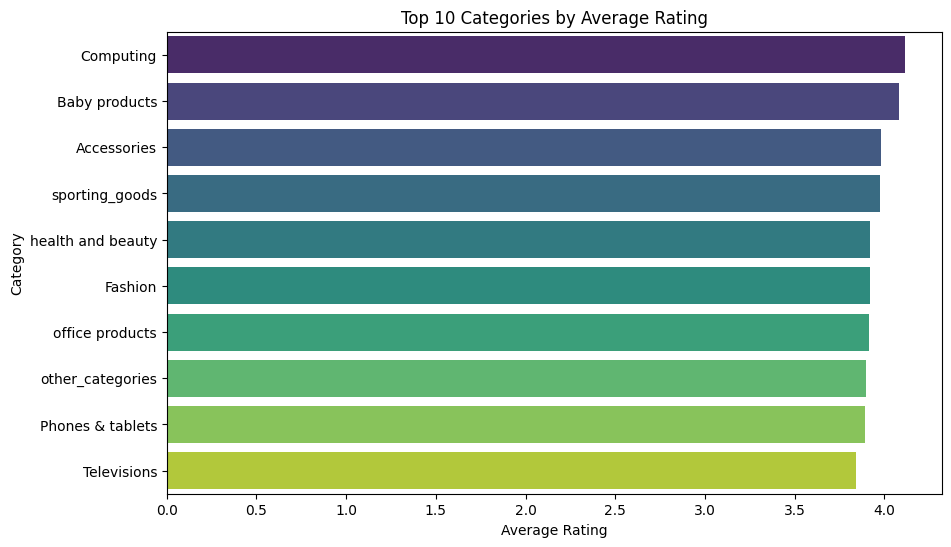

In [ ]:
# Calculate the average rating for each category
category_average_ratings = df.groupby('Category')['ratings'].mean()

# Sort the categories by average rating and get the top 10
ratings = category_average_ratings.sort_values(ascending=False).head(10)
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=ratings.values, y=ratings.index, palette='viridis')
plt.title('Top 10 Categories by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Category')
plt.show();

**Highest-Rated Category**: The first bar, `Baby products` followed closed by `Accessories`, represents the categories with the highest average rating. This suggests that customers are most satisfied with products in these categories, which might indicate superior product quality or customer satisfaction in those categories.

#### *Rating Count*

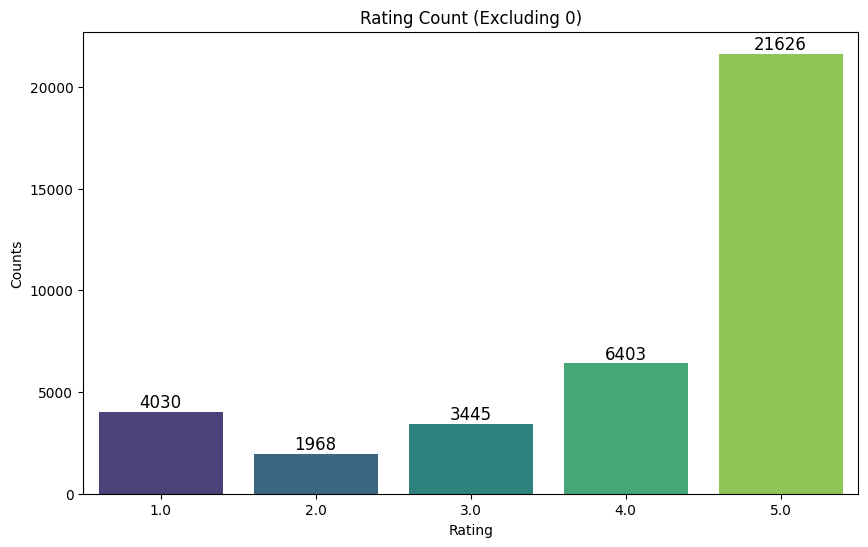

In [ ]:
# Filter out ratings of 0
filtered_ratings = df[df['ratings'] > 0]['ratings'].value_counts().sort_index()

# Plot vertical bar chart for filtered ratings count
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=filtered_ratings.index, y=filtered_ratings.values, palette='viridis')

# Annotate the bars with the count values
for i, value in enumerate(filtered_ratings.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)

plt.title('Rating Count (Excluding 0)')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.show();

From the above plot, we can see that **5** is the most rating used by the website users followed by **4** which is a clear indication majority of the products are satisfying and pleasing to the buyers.

#### *Price vs Ratings*

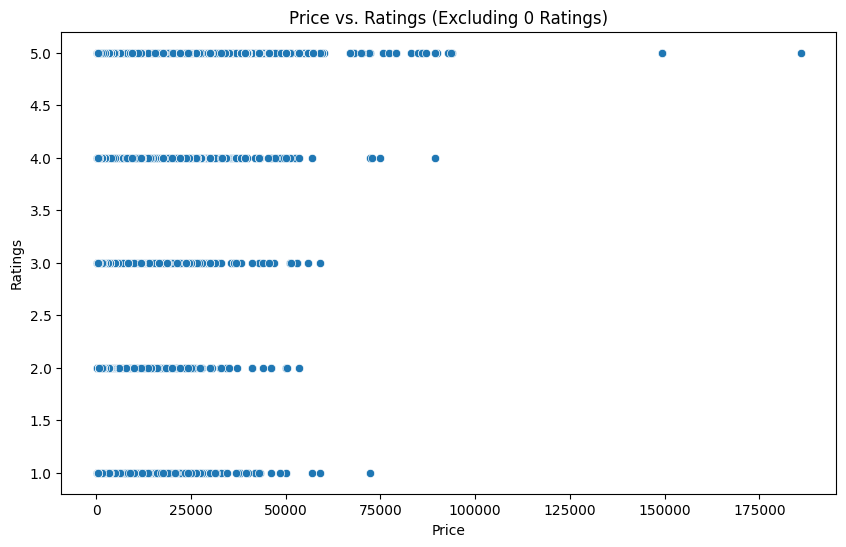

In [ ]:
# Filter out rows where ratings are 0
filtered_df = df[df['ratings'] > 0]

# Scatter plot of price vs. ratings (excluding 0 ratings)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_df['price'], y=filtered_df['ratings'])
plt.title('Price vs. Ratings (Excluding 0 Ratings)')
plt.xlabel('Price')
plt.ylabel('Ratings')
plt.show();

This scatter plot shows that:

* Products have a broad range of prices for each rating level.
* Higher ratings (3 to 5) are more frequent than lower ratings (1 or 2).
* There’s no direct correlation between price and rating based on this visual.

#### *Product branding*

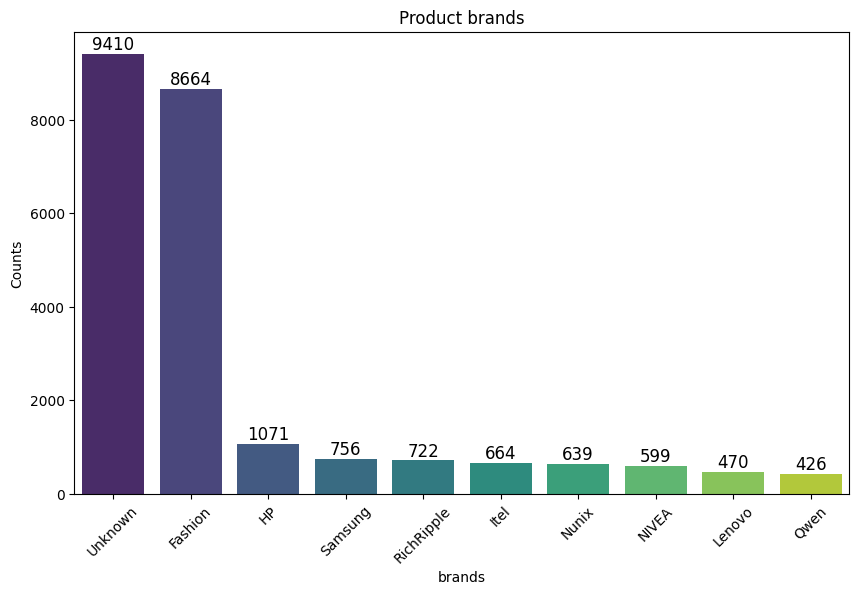

In [ ]:
# Get the product branding by count
product_brands = df['brand'].value_counts().head(10)
    
# Plot the vertical bar chart for the product branding
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=product_brands.index, y=product_brands.values, palette='viridis')
# Annotate the bars with the count values
for i, value in enumerate(product_brands.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)
plt.title('Product brands')
plt.xlabel('brands')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show();

From the above output, it is evident that majority of product's brands are not indicated in the Jumia website but for best analytical visualization we collectively gave the product's brand placeholder `Uknown`. Most of the `Fashion` seems to be branded. There is a challenge in indicating the product's brand in the website that would help site users in knowing the product brands.

#### *Frequently Listed Products*

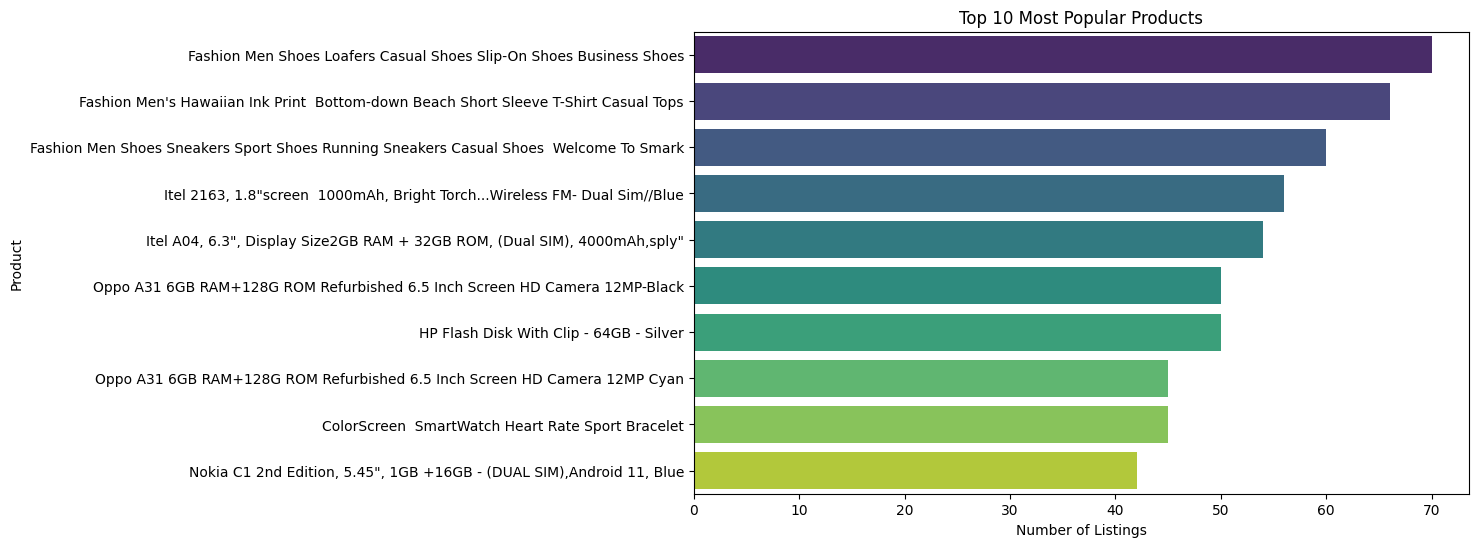

In [ ]:
# Analyzing the most frequently listed products
plt.figure(figsize=(10, 6))
top_products = df['product_name'].value_counts().head(10)
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Most Popular Products')
plt.xlabel('Number of Listings')
plt.ylabel('Product')
plt.show();

**Insights**:

* Top Product: The product with the longest bar is the most popular, possibly indicating it is a bestseller or highly favored among customers.
* Less Popular Products: The products with shorter bars are less popular, which might indicate lower sales or reduced customer preference.

### Data Preprocessing

In [ ]:
df.head()

,web-scraper-order,product_name,image,price,brand,review_title,review,ratings,user_name,Category,sub_category,overall_ratings,ratings_count
1,1730407112-2,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,Unknown,OKAY,"Working, feels cheap",3.0,WILFRED,Computing,computer-accessories,4.1,7.0
2,1730407112-3,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,Unknown,okay,A bit big for a regular laptop bag... The fanc...,4.0,Michael,Computing,computer-accessories,4.1,7.0
29,1730407173-30,Toshiba High Speed Micro SD Memory Card,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,803.0,Toshiba,good,genuine,4.0,your name,Computing,computer-accessories,4.7,3.0
30,1730407177-31,Lenovo Laptop Charger For Lenovo ThinkPad Yoga...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,4157.0,Lenovo,I like it,It worked out well,1.0,Bathsheba,Computing,computer-accessories,4.0,4.0
37,1730407197-38,"Safaricom, Airtel & Telkom -4G/3G Universal Modem",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,2600.0,Unknown,Works well,So far so good...,5.0,Ngarachu,Computing,computer-accessories,3.7,86.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38747 entries, 1 to 60399
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   web-scraper-order  38747 non-null  object 
 1   product_name       38747 non-null  object 
 2   image              38747 non-null  object 
 3   price              38747 non-null  float64
 4   brand              38747 non-null  object 
 5   review_title       38747 non-null  object 
 6   review             38747 non-null  object 
 7   ratings            38747 non-null  float64
 8   user_name          38747 non-null  object 
 9   Category           38747 non-null  object 
 10  sub_category       38747 non-null  object 
 11  overall_ratings    38747 non-null  float64
 12  ratings_count      38747 non-null  float64
dtypes: float64(4), object(9)
memory usage: 4.1+ MB


In [ ]:
df1 = df.copy()

df1.drop(['image', 'review_title', 'overall_ratings', 'ratings_count'], axis=1, inplace=True)

df1.head()

,web-scraper-order,product_name,price,brand,review,ratings,user_name,Category,sub_category
1,1730407112-2,"9""-17"" Laptop Cooling Stand Pad",3325.0,Unknown,"Working, feels cheap",3.0,WILFRED,Computing,computer-accessories
2,1730407112-3,"9""-17"" Laptop Cooling Stand Pad",3325.0,Unknown,A bit big for a regular laptop bag... The fanc...,4.0,Michael,Computing,computer-accessories
29,1730407173-30,Toshiba High Speed Micro SD Memory Card,803.0,Toshiba,genuine,4.0,your name,Computing,computer-accessories
30,1730407177-31,Lenovo Laptop Charger For Lenovo ThinkPad Yoga...,4157.0,Lenovo,It worked out well,1.0,Bathsheba,Computing,computer-accessories
37,1730407197-38,"Safaricom, Airtel & Telkom -4G/3G Universal Modem",2600.0,Unknown,So far so good...,5.0,Ngarachu,Computing,computer-accessories


### Sentiment Analysis

In [ ]:
def map_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

In [ ]:
# Applying the function to the ratings column to create a new sentiment column
df1['sentiment'] = df1['ratings'].apply(map_sentiment)

#### *Sentiment Distribution*

In [ ]:
# Checking the count of each sentiment category
sentiment_counts = df1['sentiment'].value_counts()

sentiment_counts

sentiment
Positive    28029
Negative     7273
Neutral      3445
Name: count, dtype: int64

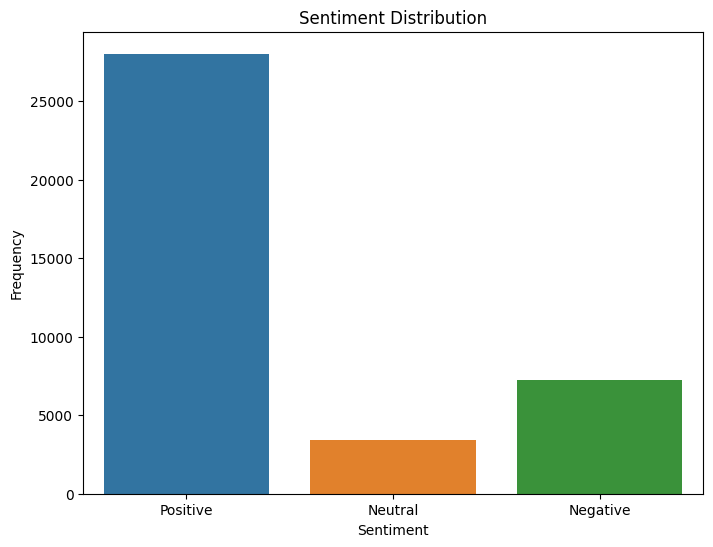

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df1, x='sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show();

In [ ]:
# Grouping by Category to see sentiment counts per category
category_sentiment = df1.groupby('Category')['sentiment'].value_counts(normalize=True).unstack()
print(category_sentiment)

sentiment          Negative   Neutral  Positive
Category                                       
Accessories        0.173535  0.076611  0.749855
Baby products      0.151976  0.087470  0.760554
Computing          0.147661  0.076321  0.776019
Fashion            0.195565  0.099446  0.704989
Phones & tablets   0.191217  0.102157  0.706626
Radios             0.323529  0.058824  0.617647
Speakers           0.248941  0.088983  0.662076
Televisions        0.199052  0.052133  0.748815
appliances         0.219771  0.073257  0.706973
health and beauty  0.189260  0.075517  0.735223
home products      0.266744  0.099592  0.633663
office products    0.190865  0.083197  0.725938
other_categories   0.188427  0.097923  0.713650
sporting_goods     0.167568  0.098198  0.734234


#### *Sentiment by Category*

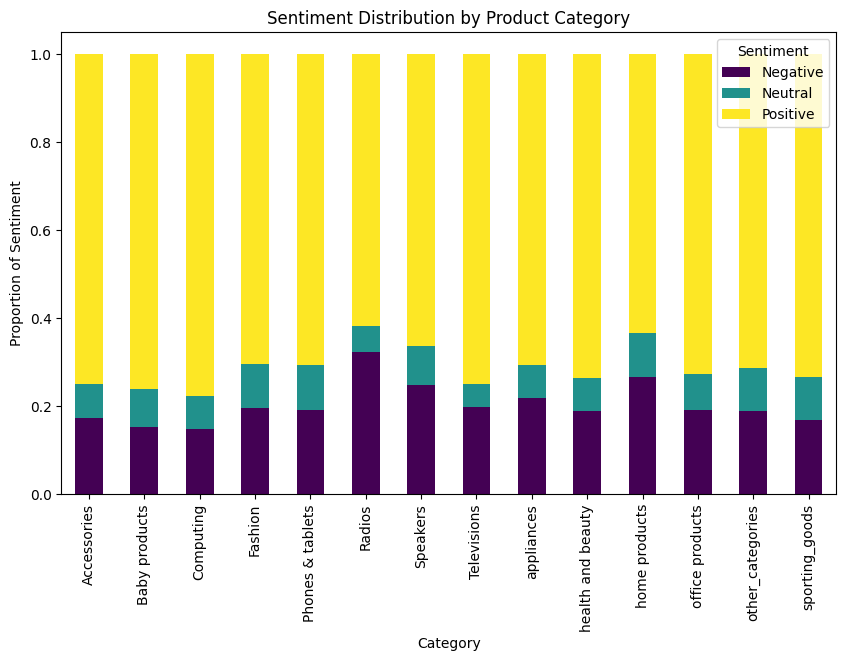

In [ ]:
# Stacked bar chart for sentiment by category
category_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6), colormap="viridis")
plt.title("Sentiment Distribution by Product Category")
plt.xlabel("Category")
plt.ylabel("Proportion of Sentiment")
plt.legend(title="Sentiment")
plt.show();

In [ ]:
df1.head()

,web-scraper-order,product_name,price,brand,review,ratings,user_name,Category,sub_category,sentiment
1,1730407112-2,"9""-17"" Laptop Cooling Stand Pad",3325.0,Unknown,"Working, feels cheap",3.0,WILFRED,Computing,computer-accessories,Neutral
2,1730407112-3,"9""-17"" Laptop Cooling Stand Pad",3325.0,Unknown,A bit big for a regular laptop bag... The fanc...,4.0,Michael,Computing,computer-accessories,Positive
29,1730407173-30,Toshiba High Speed Micro SD Memory Card,803.0,Toshiba,genuine,4.0,your name,Computing,computer-accessories,Positive
30,1730407177-31,Lenovo Laptop Charger For Lenovo ThinkPad Yoga...,4157.0,Lenovo,It worked out well,1.0,Bathsheba,Computing,computer-accessories,Negative
37,1730407197-38,"Safaricom, Airtel & Telkom -4G/3G Universal Modem",2600.0,Unknown,So far so good...,5.0,Ngarachu,Computing,computer-accessories,Positive


In [ ]:
df2 = df1[['review', 'sentiment']]

df2.head()

,review,sentiment
1,"Working, feels cheap",Neutral
2,A bit big for a regular laptop bag... The fanc...,Positive
29,genuine,Positive
30,It worked out well,Negative
37,So far so good...,Positive


In [ ]:
review = df2['review']

In [ ]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define the cleaning function
def clean_review(review):
    # Check if the review is a string (prevent errors)
    if not isinstance(review, str):
        return ""

    # Convert to lowercase
    review_lower = review.lower()

    # Remove URLs
    review_no_url = re.sub(r'http\S+|www\S+|https\S+', '', review_lower, flags=re.MULTILINE)

    # Remove mentions (@username)
    review_no_mention = re.sub(r'@\w+', '', review_no_url)

    # Remove hashtags (#topic)
    review_no_hashtag = re.sub(r'#\w+', '', review_no_mention)

    # Remove punctuation
    review_no_punc = re.sub(r'[^\w\s]', '', review_no_hashtag)

    # Remove numbers
    review_no_num = re.sub(r'\d+', '', review_no_punc)

    # Remove extra whitespace
    review_no_space = ' '.join(review_no_num.split())

    # Tokenization
    tokens = word_tokenize(review_no_space) if review_no_space.strip() else []

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Concatenate tokens back into a sentence
    cleaned_review = ' '.join(lemmatized_tokens)

    return cleaned_review

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JTG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JTG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JTG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Apply the clean_review function to each element in the 'review' column of the DataFrame
df2['cleaned_review'] = df2['review'].apply(clean_review)

In [ ]:
df2.head()

,review,sentiment,cleaned_review
1,"Working, feels cheap",Neutral,working feel cheap
2,A bit big for a regular laptop bag... The fanc...,Positive,bit big regular laptop bag fancy blue light is...
29,genuine,Positive,genuine
30,It worked out well,Negative,worked well
37,So far so good...,Positive,far good


Dropping the uncleaned `review` column

In [ ]:
df2.drop(columns='review', axis=1, inplace=True)

df2.head()

,sentiment,cleaned_review
1,Neutral,working feel cheap
2,Positive,bit big regular laptop bag fancy blue light is...
29,Positive,genuine
30,Negative,worked well
37,Positive,far good


Statistical summary

In [ ]:
df2.describe()

,sentiment,cleaned_review
count,38747,38747
unique,3,21808
top,Positive,good
freq,28029,836


#### *WordCount for Positive Sentiments*

In [ ]:
def plot_sentiment_wordcloud(df, sentiment, sentiment_column='sentiment', review_column='cleaned_review'):
    """
    Plots the word cloud for a specific sentiment.
    """
    # Join all reviews of the current sentiment into one string
    sentiment_text = " ".join(df[df[sentiment_column].str.lower() == sentiment.lower()][review_column])
    
    # Generate word cloud for the sentiment
    wordcloud = WordCloud(height=400, width=800, max_words=50, background_color="white").generate(sentiment_text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"{sentiment} Reviews")
    plt.axis("off")
    plt.show();

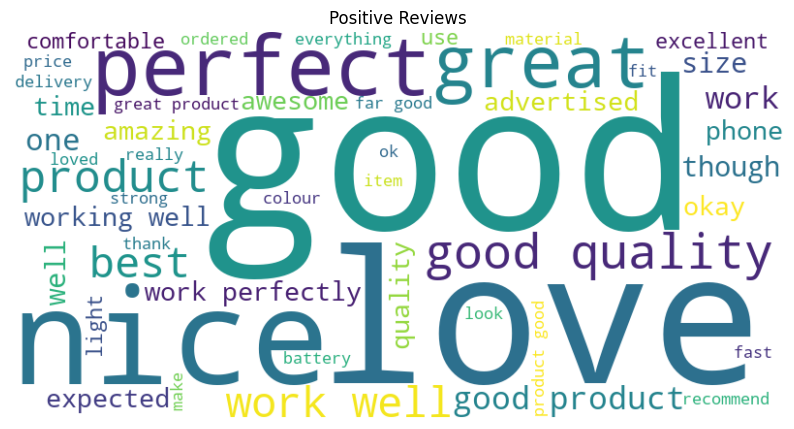

In [ ]:
plot_sentiment_wordcloud(df2, sentiment="Positive")

#### *WordCount for Negative Sentiments*

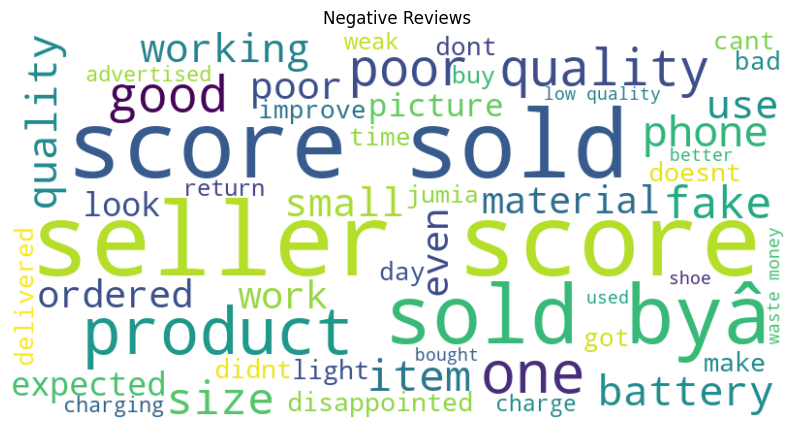

In [ ]:
plot_sentiment_wordcloud(df2, sentiment="Negative")

#### *WordCount for Neutral Sentiments*

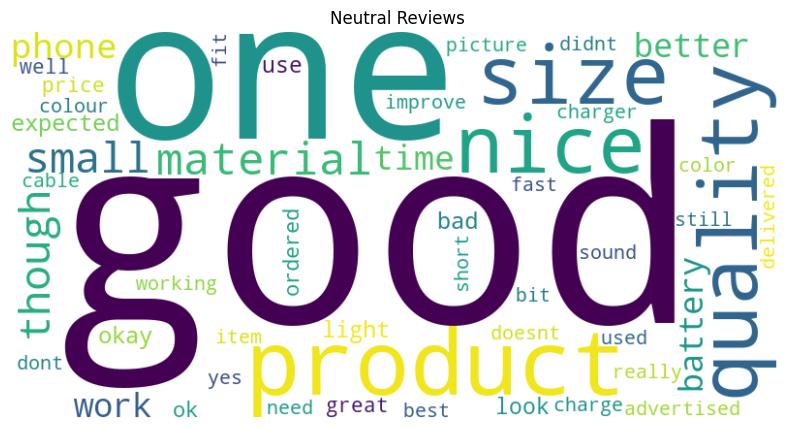

In [ ]:
plot_sentiment_wordcloud(df2, sentiment="Neutral")

#### *Split the Dataset*

In [ ]:
X = df2["cleaned_review"]
y = df2["sentiment"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 42, 
                                                    shuffle = True, 
                                                    test_size = 0.2)

#### *BOW*

In [ ]:
# Define the pipeline with CountVectorizer and LogisticRegression
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(
        tokenizer=word_tokenize,
        stop_words=nltk.corpus.stopwords.words("english"),
        ngram_range=(1, 1)
    )),
    ('classifier', LogisticRegression(
        max_iter=200,
        class_weight='balanced'
    ))
])

In [ ]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
pred = pipeline.predict(X_test)

In [ ]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

    Negative       0.73      0.65      0.69      1565
     Neutral       0.45      0.29      0.35      1188
    Positive       0.82      0.92      0.86      4997

    accuracy                           0.77      7750
   macro avg       0.67      0.62      0.63      7750
weighted avg       0.74      0.77      0.75      7750



In [ ]:
print(ConfusionMatrixDisplay.from_predictions(pred,y_test));

#### Testing BOW Model

In [ ]:
def predict_sentiment(sentences, model):
    try:
        # Clean the input sentences
        processed_sentences = [clean_review(sentence) for sentence in sentences]
        
        # Use the entire pipeline to transform and predict
        predictions = model.predict(processed_sentences)

        return predictions
    
    except NotFittedError as e:
        print(f"Error: {e}. Ensure that the pipeline is fitted on training data before using it for predictions.")

In [ ]:
# Example of model uage
new_sentences = ["This product is super cool.",
                 "Not good"]
new_predictions = predict_sentiment(new_sentences, pipeline)

print("Predictions:", new_predictions)

Predictions: ['Positive' 'Positive']


#### *TF-IDF*

In [ ]:
# Define the pipeline as pipeline1
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='word',
        stop_words=nltk.corpus.stopwords.words("english")
    )),
    ('classifier', LogisticRegression(
        max_iter=200,
        class_weight='balanced'
    ))
])

In [ ]:
# Fit the pipeline on the training data
pipeline1.fit(X_train, y_train)

# Predict on the test data
pred = pipeline1.predict(X_test)

In [ ]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

    Negative       0.73      0.64      0.68      1602
     Neutral       0.48      0.26      0.34      1377
    Positive       0.79      0.92      0.85      4771

    accuracy                           0.75      7750
   macro avg       0.67      0.61      0.62      7750
weighted avg       0.72      0.75      0.72      7750



In [ ]:
print(ConfusionMatrixDisplay.from_predictions(pred,y_test))

#### Testing TF-IDF Model

In [ ]:
# Example of model uage
new_sentences = ["This product is super cool.", 
                 "returning"]
new_predictions = predict_sentiment(new_sentences, pipeline1)

print("Predictions:", new_predictions)

Predictions: ['Positive' 'Negative']


#### *SVM Model analysis*

In [ ]:
# Define the pipeline
svm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),        # Feature extraction step
    ('svm', SVC(kernel='linear'))        # SVM classifier with a linear kernel
])

In [ ]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train the pipeline
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svm', SVC(kernel='linear'))])

In [ ]:
# Predict on the test set
y_pred = svm_pipe.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.73      0.66      0.70      1388
     Neutral       0.54      0.07      0.12       753
    Positive       0.85      0.96      0.90      5609

    accuracy                           0.82      7750
   macro avg       0.71      0.57      0.57      7750
weighted avg       0.80      0.82      0.79      7750



In [ ]:
print(ConfusionMatrixDisplay.from_predictions(y_pred,y_test))

#### Testing SVM Model

In [ ]:
# Example of model uage
new_sentences = ["This product is super cool.", 
                 "returning"]
new_predictions = predict_sentiment(new_sentences, pipeline1)

print("Predictions:", new_predictions)

Predictions: ['Positive' 'Negative']


#### *Naive Bayes classifier*

In [ ]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Vectorize the training and test data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

MultinomialNB()

In [ ]:
# Make predictions on the test set
y_pred = nb_model.predict(X_test_vec)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.81      0.58      0.67      1388
     Neutral       0.46      0.12      0.19       753
    Positive       0.83      0.97      0.90      5609

    accuracy                           0.82      7750
   macro avg       0.70      0.56      0.58      7750
weighted avg       0.79      0.82      0.79      7750



In [ ]:
print(ConfusionMatrixDisplay.from_predictions(y_pred, y_test))

#### Testing Naive Bayes Model

In [ ]:
def predict_sentiment(sentences, vectorizer, model):
    try:
        # Clean the input sentences
        processed_sentences = [clean_review(sentence) for sentence in sentences]

        # Transform the sentences using the vectorizer
        X = vectorizer.transform(processed_sentences)
        # Predict sentiment
        predictions = model.predict(X)

        return predictions
    
    except NotFittedError as e:
        print(f"Error: {e}. Ensure that the vectorizer and model are both fitted.")

In [ ]:
# Example usage
new_sentences = ["This product is super cool.", 
                 "I hate it"]
new_predictions = predict_sentiment(new_sentences, vectorizer, nb_model)

print("Predictions:", new_predictions)

Predictions: ['Positive' 'Negative']


#### *Random Forest Classifier*

In [ ]:
# Feature extraction
vectorizer1 = TfidfVectorizer()
X_fit = vectorizer1.fit_transform(X)

In [ ]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_fit, y, test_size=0.2, random_state=42)

In [ ]:
# Build and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate the model
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.77      0.70      0.74      1388
     Neutral       0.74      0.23      0.35       753
    Positive       0.87      0.97      0.91      5609

    accuracy                           0.85      7750
   macro avg       0.79      0.63      0.67      7750
weighted avg       0.84      0.85      0.83      7750



In [ ]:
print(ConfusionMatrixDisplay.from_predictions(y_pred, y_test))

#### Testing RF Model

In [ ]:
# Example usage
new_sentences = df1['review']
new_predictions = predict_sentiment(new_sentences, vectorizer1, rf_model)

print("Predictions:", new_predictions)

Predictions: ['Neutral' 'Positive' 'Positive' ... 'Positive' 'Neutral' 'Positive']


In [ ]:
df1.columns

Index(['web-scraper-order', 'product_name', 'price', 'brand', 'review',
       'ratings', 'user_name', 'Category', 'sub_category', 'sentiment'],
      dtype='object')

In [ ]:
df1['sentiment'] = new_predictions

In [ ]:
df1['sentiment'].value_counts()

sentiment
Positive    29262
Negative     6983
Neutral      2502
Name: count, dtype: int64

## Recommendation system
***
A recommendation system allows predicting the future preference list for a certain customer or user, and recommends the top preference for this user. In this project, we'll recommend products a user is likely to be from an e-commerce site. 

### 1. Unpersonalized Recommendations

* Unpersonalized Recommendations focuses on identifying popular items across a large user base rather than personalizing recommendations for individual users. In an e-commerce setting, demographic filtering can recommend products based on general popularity and positive feedback from the broader user community. This approach is often simpler, and will leverage metrics like overall ratings, ratings count, and price to identify top products.
* This technique is also useful in addressing the `cold start` problem in recommendation systems. We'll initially recommend popular products or trending items until sufficient user-item interaction data is available. New products with specific characteristics (like low price or a specific brand) can be recommended if those attributes align with popular items.



#### Weighted Rating Formula

* We'll create a Weighted Rating function, which takes into account both the average rating of each item and the number of ratings.

In [ ]:
# Drop duplicate product and only get the overall rating and rating count for each product.
df3 = df.drop_duplicates(subset=['product_name'], keep='first')

df3.shape

(6994, 13)

In [ ]:
# Compute Weighted Rating

ratings_mean = df3['overall_ratings'].mean()  # Mean of overall ratings across all products

min_ratings_count = df3['ratings_count'].quantile(0.70)  # Minimum ratings count threshold (70th percentile)
# Function to calculate weighted rating
def weighted_rating(x, m=ratings_mean, C=min_ratings_count):
    v = x['ratings_count']
    R = x['overall_ratings']
    return (v / (v + m) * R) + (m / (m + v) * C)

# Filter out products with sufficient ratings (above threshold)
qualified_data = df3[df3['ratings_count'] >= min_ratings_count].copy()

# Calculate weighted score
qualified_data['score'] = qualified_data.apply(weighted_rating, axis=1)

# Sort products based on the score
top_rated_products = qualified_data.sort_values('score', ascending=False)

* Products with the highest weighted rating.

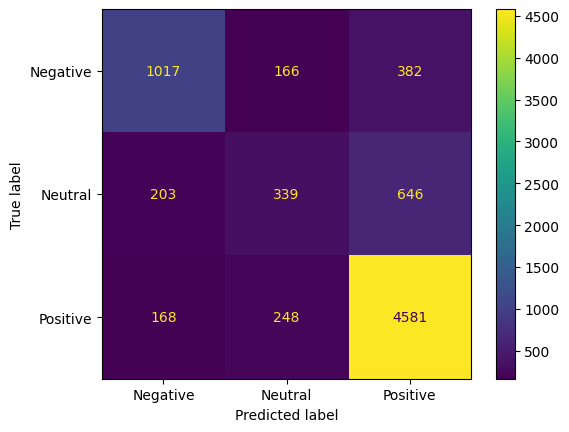

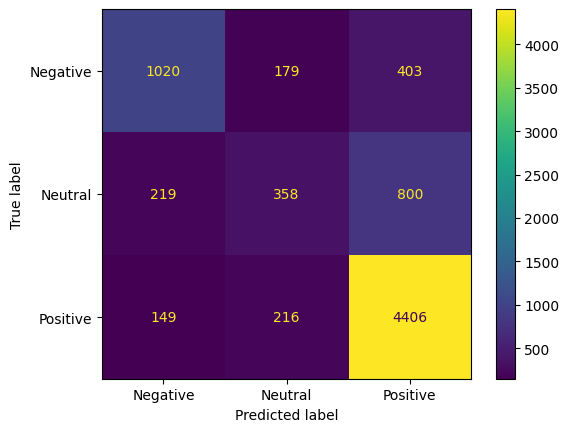

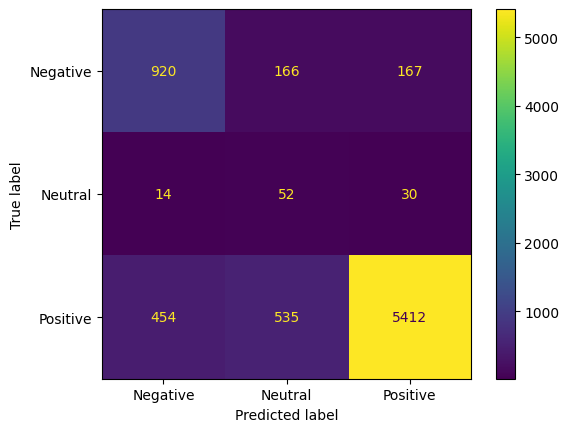

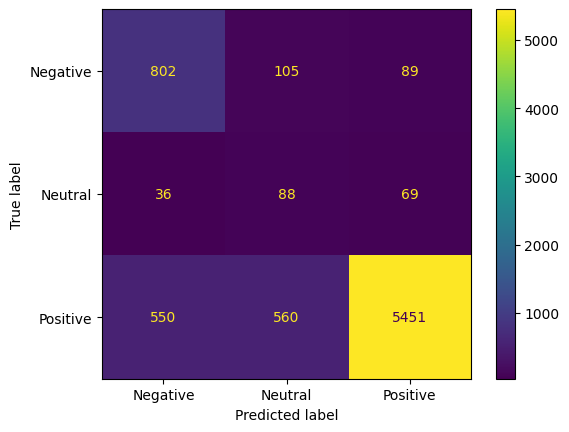

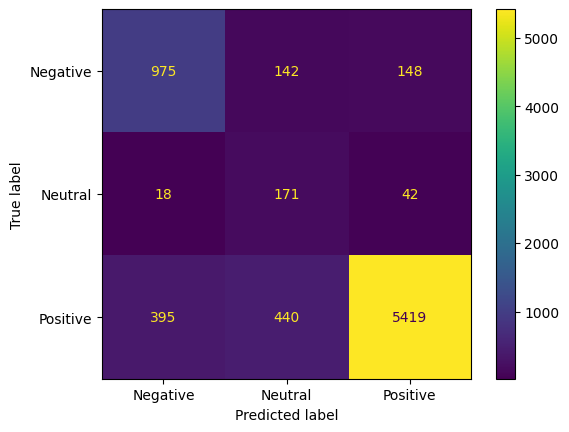

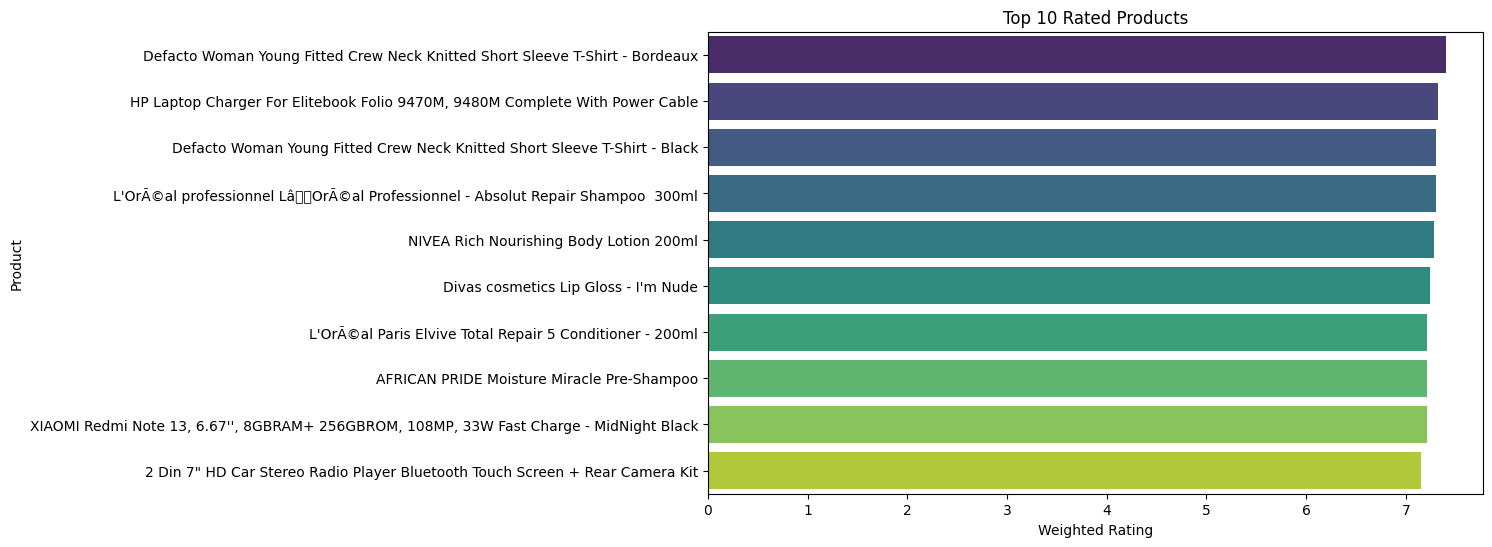

In [ ]:
# Analyzing products with the highest weighted rating.
plt.figure(figsize=(10, 6))
top_10_rated = top_rated_products.head(10)
sns.barplot(x=top_10_rated['score'], y=top_10_rated['product_name'], palette='viridis')
plt.title('Top 10 Rated Products')
plt.xlabel('Weighted Rating')
plt.ylabel('Product')
plt.show();

* Categories with the highest weighted rating.

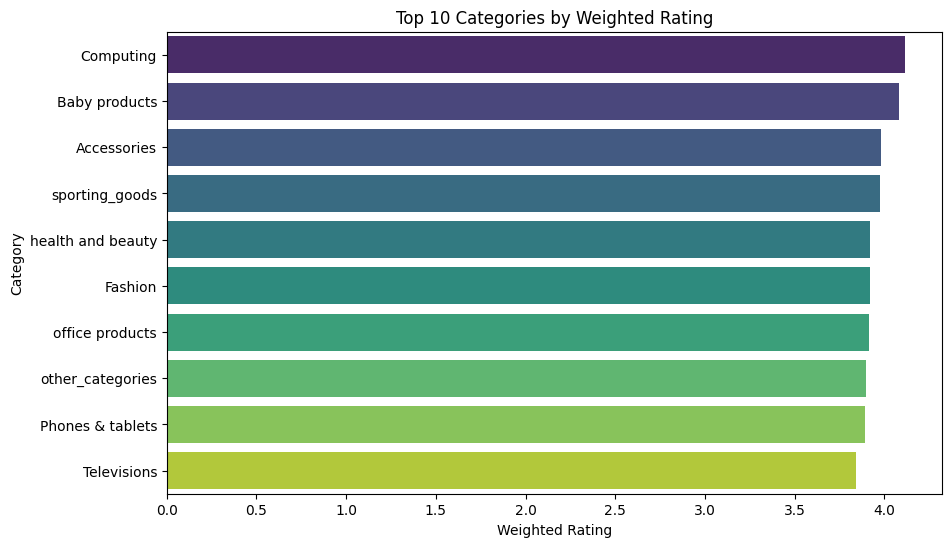

In [ ]:
# Calculate the weighted rating for each category
subcategory_overall_ratings = qualified_data.groupby('Category')['score'].mean()

# Sort the categories by weighted rating and get the top 10
ratings = category_average_ratings.sort_values(ascending=False).head(10)
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=ratings.values, y=ratings.index, palette='viridis')
plt.title('Top 10 Categories by Weighted Rating')
plt.xlabel('Weighted Rating')
plt.ylabel('Category')
plt.show();

### 2. Personalized Recommendations

* Personalized Recommendations can be summarized as: Given the profile of the `active` user and possibly some situational context, i.e. user browsing a product or making a purchase, creating a set of items, and a score for each recommendable item in that set.
Personalized Recommendations are grouped as shown below:

i. Collaborative Filtering: **
* `User-Based:` Recommends items based on similar users’ preferences.

* `Item-Based:` Recommends items similar to those the user has liked in the past.

ii. Content-Based Filtering: **
* Uses item metadata (e.g., product descriptions, tags) to recommend similar items to those the user has previously liked.

3. Hybrid Methods: 
* Combines multiple approaches to improve performance and address the limitations of individual methods.

In [ ]:
df.columns

Index(['web-scraper-order', 'product_name', 'image', 'price', 'brand',
       'review_title', 'review', 'ratings', 'user_name', 'Category',
       'sub_category', 'overall_ratings', 'ratings_count'],
      dtype='object')

#### i) Collaborative Filtering

* Collaborative filtering can be implemented using user-based or item-based techniques. A common method in collaborative filtering is to use matrix factorization, such as Singular Value Decomposition (SVD), which is effective for predicting ratings based on past user interactions.

1. Item based

In [ ]:
ratings_matrix = df3.pivot_table(index='product_name', columns='user_name', values='ratings').fillna(0)

In [ ]:
# Initialize Truncated SVD
svd = TruncatedSVD(n_components=50, random_state=42)  # Adjust components as necessary

# Fit and transform the ratings matrix
latent_matrix = svd.fit_transform(ratings_matrix)

# Compute cosine similarity on the reduced matrix
similarity_matrix = cosine_similarity(latent_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=ratings_matrix.index, columns=ratings_matrix.index)

In [ ]:
# Recommendation function using similarity matrix from SVD
def recommend_items(product_name, num_recommendations=5):
    # Check if the product exists in the similarity matrix
    if product_name not in similarity_df.index:
        print(f"Product '{product_name}' not found in the dataset.")
        return []
    
    # Retrieve similarity scores for the specified product
    sim_scores = similarity_df[product_name]
    
    # Sort scores in descending order and exclude the product itself
    sim_scores = sim_scores.sort_values(ascending=False).drop(product_name)
    
    # Get the top recommendations
    top_items = sim_scores.head(num_recommendations).index
    top_scores = sim_scores.head(num_recommendations).values
    
    recommendations = list(zip(top_items, top_scores))
    return recommendations

In [ ]:
recommend_items('Fashion Women Two-Tone Be Graffiti Charm Pendant Necklace Sister-')

[('1.2M Computer Office Desk Workstation With Metal Frame (Unassembled)', 1.0),
 ('Fashion 2PCs Cutest Warm Knitted 1Baby Cap&1Matching Scarf', 1.0),
 ('Mom Easy Wide Neck Feeding Bottle With Soft Nipple 240ML (Twin-pack)', 1.0),
 ('Fashion Mens Formal Shirts Casual Round Neck Short Sleeved T-shirt Polos-Black',
  1.0),
 ('Nunix 100 Litres Freezer Fridge (1YR WRTY)', 0.9156823839016427)]

Testing and Evaluation

In [ ]:
# Function to display recommendations
def display_recommendations(product_name, data, num_recommendations=5):
    # Get the list of recommended items with similarity scores
    recommendations = recommend_items(product_name, num_recommendations)
    
    # Print the original product for context
    print(f"Recommendations for '{product_name}':\n")
    
    # Loop through the recommendations and display details from the dataset
    for rec, score in recommendations:
        # Filter the dataset to get details of the recommended item
        rec_data = data[data['product_name'] == rec]
        
        if not rec_data.empty:
            print(f"Product Name: {rec_data['product_name'].values[0]}")
            print(f"Category: {rec_data['Category'].values[0]}")
            print(f"Ratings: {rec_data['overall_ratings'].values[0]}")
            print(f"Price: {rec_data['price'].values[0]}")
            print(f"Similarity Score: {score:.2f}")
            print("—" * 20)
        else:
            print(f"Details for '{rec}' not found in dataset.")


In [ ]:
# Test the recommendation function
display_recommendations('Fashion 2PCs Cutest Warm Knitted 1Baby Cap&1Matching Scarf', df3, num_recommendations=5)

Recommendations for 'Fashion 2PCs Cutest Warm Knitted 1Baby Cap&1Matching Scarf':

Product Name: Mom Easy Wide Neck Feeding Bottle With Soft Nipple 240ML (Twin-pack)
Category: Baby products
Ratings: 4.7
Price: 1050.0
Similarity Score: 1.00
————————————————————
Product Name: Fashion Women Two-Tone Be Graffiti Charm Pendant Necklace Sister-
Category: Fashion
Ratings: 4.1
Price: 124.0
Similarity Score: 1.00
————————————————————
Product Name: Fashion Mens Formal Shirts Casual Round Neck Short Sleeved T-shirt Polos-Black
Category: Fashion
Ratings: 3.9
Price: 643.0
Similarity Score: 1.00
————————————————————
Product Name: 1.2M Computer Office Desk Workstation With Metal Frame (Unassembled)
Category: office products
Ratings: 3.8
Price: 5524.0
Similarity Score: 1.00
————————————————————
Product Name: Size 5 Soccer Ball  Blue & White
Category: sporting_goods
Ratings: 3.9
Price: 1130.0
Similarity Score: 0.92
————————————————————


2. User based

In [ ]:
user_item_matrix = df.pivot_table(index='user_name', columns='product_name', values='ratings').fillna(0)

In [ ]:
# Initialize Truncated SVD
n_components = 20  # Number of latent features, can be tuned
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit and transform the user-item matrix
user_item_svd_matrix = svd.fit_transform(user_item_matrix)

# Convert the transformed data to a DataFrame
svd_df = pd.DataFrame(user_item_svd_matrix, index=user_item_matrix.index)


In [ ]:
# Compute cosine similarity between users
user_similarity_matrix = cosine_similarity(svd_df)
user_similarity_df = pd.DataFrame(user_similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

In [ ]:
#Recommendation function
def recommend_items(user_name, num_recommendations=5):
    # Check if the user exists in the similarity DataFrame
    if user_name not in user_similarity_df.columns:
        print(f"User '{user_name}' not found.")
        return []
    
    # Find similar users to the given user
    similar_users = user_similarity_df[user_name].sort_values(ascending=False).index[1:]  # Exclude the user themselves
    
    # Initialize a dictionary to hold potential recommendations and their weighted scores
    recommendations = {}
    
    # Iterate over similar users
    for sim_user in similar_users:
        user_ratings = user_item_matrix.loc[sim_user]
        
        # Weight each item by similarity score and accumulate in recommendations dictionary
        for item, rating in user_ratings.items():
            if rating > 0:  # Assuming 0 indicates no rating
                recommendations[item] = recommendations.get(item, 0) + rating * user_similarity_df.loc[sim_user, user_name]
    
    # Sort recommendations by weighted score
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    
    # Return top recommendations
    top_recommendations = [item for item, score in sorted_recommendations[:num_recommendations]]
    return top_recommendations

Testing and Evaluation

In [ ]:
# Recommendation display function
def display_user_recommendations(user_name, data, num_recommendations=5):
    # Get the list of recommended items for the user
    recommendations = recommend_items(user_name, num_recommendations)
    
    # Print the original user for context
    print(f"Recommendations for User '{user_name}':\n")
    
    # Loop through the recommendations and display details from the dataset
    for rec in recommendations:
        # Filter the dataset to get details of the recommended item
        rec_data = data[data['product_name'] == rec]
        
        if not rec_data.empty:
            print(f"Product Name: {rec_data['product_name'].values[0]}")
            print(f"Category: {rec_data['Category'].values[0]}")
            print(f"Ratings: {rec_data['overall_ratings'].values[0]}")
            print(f"Price: {rec_data['price'].values[0]}")
            print("—" * 20)
        else:
            print(f"Details for '{rec}' not found in dataset.")


In [ ]:
unique_user_names = df['user_name'].unique()

# Display the user names
print("Unique User Names in Dataset:")
print(unique_user_names)

Unique User Names in Dataset:
[' WILFRED' ' Michael' ' your name' ... ' Antonina' ' Ahlam' ' ritah']


In [ ]:
user_name_to_test = 'Antonia'
display_user_recommendations(user_name_to_test, df)

User 'Antonia' not found.
Recommendations for User 'Antonia':



#### ii) Content-Based Filtering
*  Content-based filtering focuses on recommending items similar to those a user has liked in the past, using attributes or features of the items themselves rather than relying on user interactions. Each item is analyzed based on its characteristics (e.g., genre, keywords, product features), and recommendations are made based on matching these features.

In [ ]:
# Combine the features
df3['combined_features'] = (df3['product_name'].fillna('') + df3['brand'].fillna('') + df3['review_title'].fillna('') + df3['review'].fillna(''))

In [ ]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df3['combined_features'])

In [ ]:
# Set the number of latent features (e.g., 50)
n_components = 50

# Initialize and apply TruncatedSVD
svd = TruncatedSVD(n_components=n_components, random_state=42)
item_features_matrix = svd.fit_transform(tfidf_matrix)

In [ ]:
# Calculate cosine similarity on the SVD-transformed matrix
cosine_sim = cosine_similarity(item_features_matrix)
# Convert to DataFrame for ease of use
cosine_sim_df = pd.DataFrame(cosine_sim, index=df3['product_name'], columns=df3['product_name'])

In [ ]:
# Build a recommendation Function
def recommend_items(product_name, num_recommendations=5):
    # Combine the features
    df3['combined_features'] = (df3['product_name'].fillna('') + df3['brand'].fillna('') + df3['review_title'].fillna('') + df3['review'].fillna(''))
    # Initialize TF-IDF Vectorizer
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df3['combined_features'])

    # Set the number of latent features (e.g., 50)
    n_components = 50

    # Initialize and apply TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    item_features_matrix = svd.fit_transform(tfidf_matrix)
    
    # Calculate cosine similarity on the SVD-transformed matrix
    cosine_sim = cosine_similarity(item_features_matrix)
    # Convert to DataFrame for ease of use
    cosine_sim_df = pd.DataFrame(cosine_sim, index=df3['product_name'], columns=df3['product_name'])
    # Check if the product exists in the similarity DataFrame
    if product_name not in cosine_sim_df.columns:
        print(f"Product '{product_name}' not found in dataset.")
        return []
    
    # Get similarity scores for the product and sort by descending order
    sim_scores = cosine_sim_df[product_name].sort_values(ascending=False)
    
    # Exclude the product itself from recommendations
    sim_scores = sim_scores.drop(product_name)
    
    # Get the top recommendations based on similarity scores
    top_recommendations = sim_scores.head(num_recommendations).index.tolist()
    
    return top_recommendations

Testing and Evaluation

In [ ]:
# Recommendation display function
def display_recommendations(product_name, data, num_recommendations=5):
    # Get the list of recommended items
    recommendations = recommend_items(product_name, num_recommendations)
    
    # Print the original product for context
    print(f"Recommendations for '{product_name}':\n")
    
    # Loop through the recommendations and display details from the dataset
    for rec in recommendations:
        # Filter the dataset to get details of the recommended item
        rec_data = data[data['product_name'] == rec]
        
        if not rec_data.empty:
            print(f"Product Name: {rec_data['product_name'].values[0]}")
            print(f"Category: {rec_data['Category'].values[0]}")
            print(f"Ratings: {rec_data['overall_ratings'].values[0]}")
            print(f"Price: {rec_data['price'].values[0]}")
            print("—" * 20)
        else:
            print(f"Details for '{rec}' not found in dataset.")

In [ ]:
# Example with a product name
display_recommendations('Fashion Mens Formal Shirts Casual Round Neck Short Sleeved T-shirt Polos-Black', df3)

Recommendations for 'Fashion Mens Formal Shirts Casual Round Neck Short Sleeved T-shirt Polos-Black':

Product Name: Fashion Mens Formal Shirts Casual Round Neck Short Sleeved T-shirt Polos-Blue
Category: Fashion
Ratings: 3.0
Price: 780.0
————————————————————
Product Name: Fashion Summer Mens Loose Vintage Short Sleeve Hawaii Beach Shirts  - Rainbow
Category: Fashion
Ratings: 3.6
Price: 747.0
————————————————————
Product Name: Fashion Mens Polos Casual Trendy T-shirt Joggers Short Sleeve Shirts Official - Navy
Category: Fashion
Ratings: 3.7
Price: 745.0
————————————————————
Product Name: Fashion Mens Formal Shirts Casual Round Neck Short Sleeved T-shirt Polos - White
Category: Fashion
Ratings: 3.9
Price: 757.0
————————————————————
Product Name: Fashion Mens T-shirt Turtle Neck Sweatshirt Casual Long Sleeve Shirts-White
Category: Fashion
Ratings: 3.8
Price: 600.0
————————————————————


In [ ]:
# Calculate content-based similarity score
def similarity_score_recommendations(product_name, cosine_sim_df, num_recommendations=5):
    if product_name not in cosine_sim_df.columns:
        print(f"Product '{product_name}' not found in dataset.")
        return
    
    # Get similarity scores for the product and sort by descending order
    sim_scores = cosine_sim_df[product_name].sort_values(ascending=False)
    sim_scores = sim_scores.drop(product_name)  # Drop the input product itself

    # Print the similarity scores for each recommended item
    print(f"Similarity scores for recommendations for '{product_name}':")
    for i, (rec, score) in enumerate(sim_scores.head(num_recommendations).items(), 1):
        print(f"{i}. {rec} - Similarity Score: {score:.2f}")

In [ ]:
similarity_score_recommendations('Fashion Mens Formal Shirts Casual Round Neck Short Sleeved T-shirt Polos-Black', cosine_sim_df)

Similarity scores for recommendations for 'Fashion Mens Formal Shirts Casual Round Neck Short Sleeved T-shirt Polos-Black':
1. Fashion Mens Formal Shirts Casual Round Neck Short Sleeved T-shirt Polos-Blue - Similarity Score: 0.97
2. Fashion Summer Mens Loose Vintage Short Sleeve Hawaii Beach Shirts  - Rainbow - Similarity Score: 0.93
3. Fashion Mens Polos Casual Trendy T-shirt Joggers Short Sleeve Shirts Official - Navy - Similarity Score: 0.93
4. Fashion Mens Formal Shirts Casual Round Neck Short Sleeved T-shirt Polos - White - Similarity Score: 0.92
5. Fashion Mens T-shirt Turtle Neck Sweatshirt Casual Long Sleeve Shirts-White - Similarity Score: 0.92


In [ ]:
df3 = df3.rename(columns={'web-scraper-order': 'id'})

In [ ]:
df3['id'] = df3['id'].str.replace('-', '')

In [ ]:
df3['id'] = pd.to_numeric(df3['id'], errors='coerce')

In [ ]:
df3['id']

1          17304071122
29        173040717330
30        173040717731
37        173040719738
48        173040720949
             ...      
60384    1730674142101
60388    1730674160105
60390    1730674183107
60396    1730674213113
60398    1730674248115
Name: id, Length: 6994, dtype: int64

In [ ]:
df3.columns

Index(['id', 'product_name', 'image', 'price', 'brand', 'review_title',
       'review', 'ratings', 'user_name', 'Category', 'sub_category',
       'overall_ratings', 'ratings_count', 'combined_features'],
      dtype='object')

In [ ]:
# Pickle the unique products to a file
with open("products_list.pkl", "wb") as f:
    dill.dump(df3, f)

In [ ]:
# Pickle the unique products to a file
with open("top_rated_products.pkl", "wb") as f:
    dill.dump(top_rated_products, f)

In [ ]:
df1 = df1.rename(columns={'web-scraper-order': 'id'})
df1['id'] = df1['id'].str.replace('-', '')
df1['id'] = pd.to_numeric(df1['id'], errors='coerce')

In [ ]:
df1.dtypes

id                int64
product_name     object
price           float64
brand            object
review           object
ratings         float64
user_name        object
Category         object
sub_category     object
sentiment        object
dtype: object

In [ ]:
df1.duplicated().sum()

0

In [ ]:
df1.drop_duplicates(inplace=True)

In [ ]:
first_ids = df1.groupby('product_name')['id'].transform('first')

In [ ]:
df1['id'] = first_ids

In [ ]:
# Pickle the unique products to a file
with open("sentiments.pkl", "wb") as f:
    dill.dump(df1, f)

In [ ]:
# Assuming df is your DataFrame
def process_dataframe(df):
    # Group by category and sort by ratings to get top products in each category
    top_rated_by_category = (
        df.sort_values(by="ratings_count", ascending=False)
          .groupby("Category")
          .head(10)  # Adjust this number based on the number of top products you want per category
    )
    return top_rated_by_category.to_dict(orient="records")

In [ ]:
def precompute_similarity(products, output_file="similarity_matrix.pkl"):
    # Combine features
    products['combined_features'] = (
        products['product_name'].fillna('') +
        products['brand'].fillna('') +
        products['review_title'].fillna('') +
        products['review'].fillna('')
    )
    # Vectorize features
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(products['combined_features'])

    # Apply TruncatedSVD
    n_components = 20
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    item_features_matrix = svd.fit_transform(tfidf_matrix)

    # Compute cosine similarity
    cosine_sim = cosine_similarity(item_features_matrix)

    # Save similarity matrix and product IDs
    with open(output_file, 'wb') as f:
        dill.dump({'similarity_matrix': cosine_sim, 'ids': products['id'].values}, f)


precompute_similarity(top_100_by_category)


In [ ]:
top_100_by_category = (
        df3.sort_values(by="ratings_count", ascending=False)
          .groupby("Category")
          .head(100)  # Adjust this number based on the number of top products you want per category
    )

In [ ]:
top_100_by_category.columns

Index(['id', 'product_name', 'image', 'price', 'brand', 'review_title',
       'review', 'ratings', 'user_name', 'Category', 'sub_category',
       'overall_ratings', 'ratings_count', 'combined_features'],
      dtype='object')